In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from FDTDStaggered3D_with_relaxation.H5pySimple import ReadFromH5py,SaveToH5py
from FDTDStaggered3D_with_relaxation.PropagationModel import PropagationModel

PModel=PropagationModel()


StaggeredFDTD_3D_CUDA NOT loaded
StaggeredFDTD_3D_OPENCL loaded


# Simple case of Water only simulation - plane circular transducer
In this simple example we will cover the basics of the FDTDStaggered3D operation, which involves:
* Defining a dmoain size
* Specifying an acoustic source
* Specifying regions of domain as sensors
* Execute simulation and show results

## Defintions of medium-domain
First step is to define a domain, in this example we will execute a simulation of a piston source (diam of 3 cm) operating at 350 kHz in a water-only domain of 5$\times$5$\times$10 cm. You can see below how the perfect matching layer (PML) needs to be accounted.

In [2]:
Frequency = 350e3  # Hz
MediumSOS = 1500 # m/s - water
MediumDensity=1000 # kg/m3

ShortestWavelength =MediumSOS / Frequency
SpatialStep =ShortestWavelength / 8.0 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.05,0.05,0.1])  # in m, x,y,z

TxDiam = 0.03 # m, ciruclar piston
TxPlaneLocation = 0.01  # m , in XY plane at Z = 0.01 m

PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, IGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/MediumSOS #time to cross one corner to another
TemporalStep=1e-7 # if this step is too coarse a warning will be generated (but simulation will continue,) 

Domain size 118 118 211


## Material map definition
The material map is a finite distribution of the type of materials present in the simulation domain. In this example, a simple homogenous map is present.

A material list is an array of N$\times$5 where N is the number of different materials.
* The first column (0) is **density** (kg/m$^3$)
* The second column (1) is **Longitudinal speed of sound** (m/s)
* The third column (2) is **Shear speed of sound** (m/s)
* The fourth column (3) is **Longitudinal attenuation** (Np/m)
* The fifth column (4) is **Shear attenuation** (Np/m)

In [3]:
MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((1,5)) # one material in this examples
MaterialList[0,0]=MediumDensity # water density
MaterialList[0,1]=MediumSOS # water SoS
#all other parameters are set to 0 


## Source definition
The **source map** is a N1$\times$N2$\times$N3 integer array where anything different from 0 is considered a source. A **Pulse source** array with M$\times$number-of-time-points is associated to the source map. For example, entries in the source map with a value of 1 mean that those entries will use the source function in pulse source at location [0,:]; entries in the source map with a value of 4 mean they will use the  source function in pulse source at location [3,:]. Note the index in the pulse source is -1 compared to the source map (1->0, 2->1, and so on).

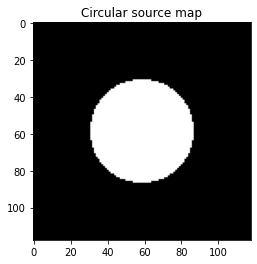

In [4]:
def MakeCircularSource(DimX,DimY,SpatialStep,Diameter):
    #simple defintion of a circular source centred in the domain
    XDim=np.arange(DimX)*SpatialStep
    YDim=np.arange(DimY)*SpatialStep
    XDim-=XDim.mean()
    YDim-=YDim.mean()
    XX,YY=np.meshgrid(XDim,YDim)
    MaskSource=(XX**2+YY**2)<=(Diameter/2.0)**2
    return (MaskSource*1.0).astype(np.uint32)

SourceMask=MakeCircularSource(N1,N2,SpatialStep,TxDiam)
plt.imshow(SourceMask,cmap=plt.cm.gray);
plt.title('Circular source map')

SourceMap=np.zeros((N1,N2,N3),np.uint32)
LocZ=int(np.round(TxPlaneLocation/SpatialStep))+PMLThickness
SourceMap[:,:,LocZ]=SourceMask 

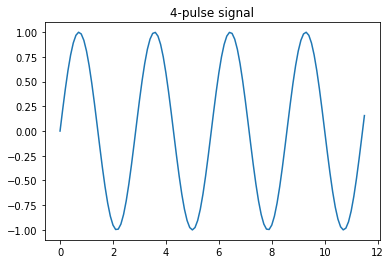

In [5]:


LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 

## Sensor map definition
The **sensor map** is a N1$\times$N2$\times$N3 integer array where anything different from 0 is considered a sensor. Sensor map will specify locations where temporal data will be collected.
In this example, we will collect data in the central plane.

Text(0.5, 1.0, 'Sensor map location')

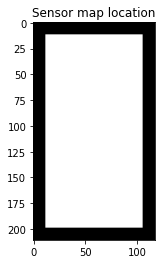

In [6]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

plt.figure()
plt.imshow(SensorMap[:,int(N2/2),:].T,cmap=plt.cm.gray)
plt.title('Sensor map location')

## Verify conditions of simulation - optional
The simulation is executed with the function `StaggeredFDTD_3D_with_relaxation`. However, if passing the parameter `CheckOnlyParams=True` a quick verifcation of the simulation conditions is executed, especially regarding the temporal step that can be used to verify stability conditions are met. Also, to identify potential mistakes in much more complex domains (such as transmission through bone material) in the definition of density, speeds of sound, etc. The viscoelastic simulation will transform the definition of the acoustic domain into elastic conditions via Lamé parameters ($\mu$, $\lambda$). For example, the Poison ratio of every voxel must be between -1.0 and 0.5. Any value ourside that range would suggest that a mistake in material definition took place. Attenuation coefficients are transformed to $Q$-factor coefficients that use memory-type matrices to model attenuation losses. Consult the `PropagationModel.py` file for details.

In [7]:
StabilityConditions,largestDT=PModel.StaggeredFDTD_3D_with_relaxation(MaterialMap,
                                             MaterialList,
                                             Frequency,
                                             SourceMap,
                                             PulseSource,
                                             TimeVectorSource,
                                             SpatialStep,
                                             TimeSimulation,
                                             SensorMap,
                                             IntervalSnapshots=2e-6, 
                                             NDelta=PMLThickness,
                                             ReflectionLimit=ReflectionLimit,
                                             COMPUTING_BACKEND=1,
                                             USE_SINGLE=True,
                                             DT=TemporalStep,
                                             QfactorCorrection=True,
                                             DefaultGPUDeviceName='SUPER',
                                             TypeSource=1,
                                             USE_SPP=0,
                                             Ox=0.0,Oy=0.0,Oz=1.0,
                                             CheckOnlyParams=True)
#If returns True, it means stability conditions are met, the largest value of temporal step is printed for reference
print('Conditions of stability =',StabilityConditions,', largest dt',largestDT)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
Conditions of stability = True , largest dt 1.749724795401213e-07


## Execute simulation
To execute the simulation, call the same function without `CheckOnlyParams` (or set to `FALSE`). Besides the parameters specifying the domain, source and sensors
* `MaterialMap` 3D distribution of different types of material (uint 32)
* `MaterialList` Properties of materials (described above) (N$\times$ 5, N is maximal type of material, double)
* `Frequency` (Hz, double)
* `SourceMap` 3D distribution of source location (described above)
* `PulseSource` Time-domain functions of sources (described above)
*  `SpatialStep` Spatial step of domain (m, only isotropic conditions are supported, double)
* `TimeSimulation` Duration of simulation (s, double)
* `SensorMap` 3D dsitribution of location of sensors (described above)
* `IntervalSnapshots`, 

In [16]:
realDT,Sensor,LastMap,RMSValue,AnalysisQFactorLong,AnalysisQFactorShear,SnapShots,PoissonRatio,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         TimeVectorSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         IntervalSnapshots=2e-6, 
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=2,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         DefaultGPUDeviceName='Radeon',
                                                         TypeSource=1,
                                                         USE_SPP=0,
                                                         Ox=0.0,Oy=0.0,Oz=1.0)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 118 x 118 x 211 , spatial resolution = 0.000535714, time steps = 817, temporal step = 1e-07, total sonication length 8.16497e-05 
Performing Simulation wtih GPU OPENCL
Copying opencl files from /Users/spichardo/.edm/envs/MORPHEUS36/include/python3.6m/FDTDStaggered3D-with-relaxation/ to /Users/spichardo/Documents/GitHub/FDTDStaggered3D_with_relaxation/Example Notebooks
Running with new interface conditions
SizePML=1285633
SizePMLxp1=1310531
SizePMLyp1=1310531
SizePMLzp1=1299557
SizePMLxp1yp1zp1=1349801
 Staggered FDTD - compiled at Dec 27 2020 - 10:13:55
N1, N2,N3 , ZoneCount and D

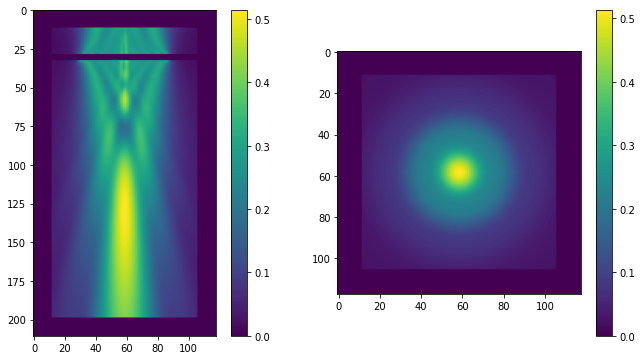

In [17]:
RMSValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,125].T)
plt.colorbar()

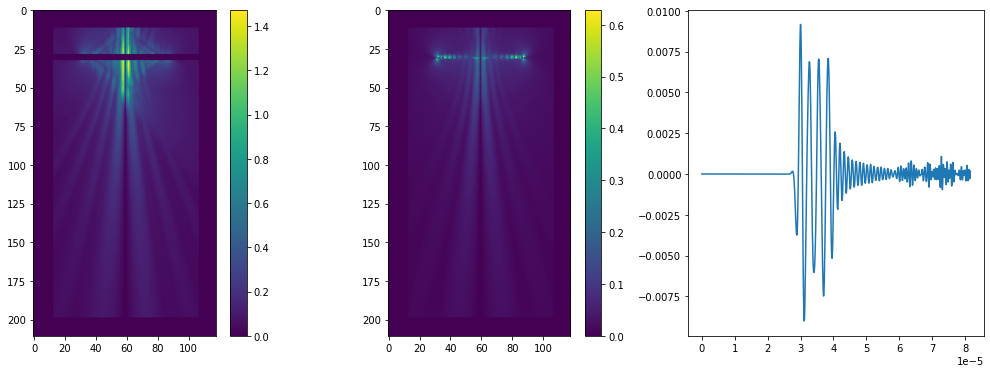

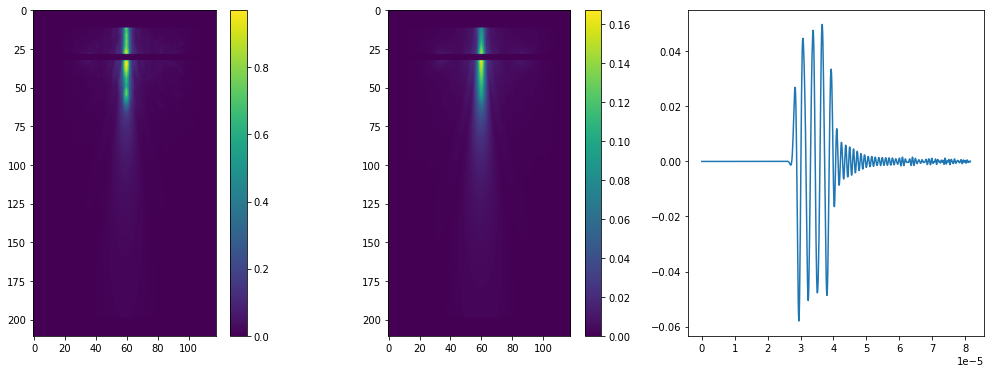

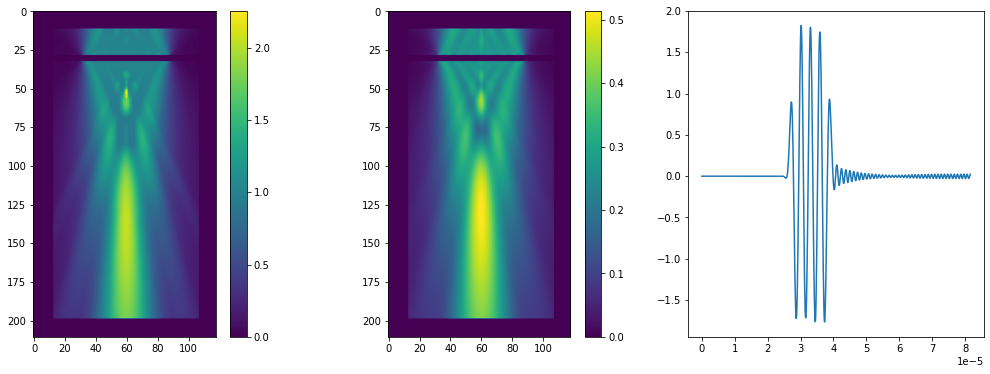

In [18]:
#To remain compatible with Matlab (whcih uses a Fortran convention for arrays, the index need to be rebuilt)
MaxSensorPlaneVx=np.zeros((N1,N3))
RMSSensorPlaneVx=np.zeros((N1,N3))
MaxSensorPlaneVy=np.zeros((N1,N3))
RMSSensorPlaneVy=np.zeros((N1,N3))
MaxSensorPlaneVz=np.zeros((N1,N3))
RMSSensorPlaneVz=np.zeros((N1,N3))
for n, index in enumerate( InputParam['IndexSensorMap']):
    k=int(index/(N1*N2))
    j=int(index%(N1*N2))
    i=int(j%N1)
    j=int(j/N1)
    assert(j==N2/2) #all way up we set the XZ plane at N2/2
    if i==int(N1/2) and k==int(N3/2):
        CentralPoint=n #we save this to later plot the time signal at the center
    MaxSensorPlaneVx[i,k]=np.max(Sensor['Vx'][n,:])
    RMSSensorPlaneVx[i,k]=np.sqrt(1./len(Sensor['Vx'][n,:])*np.sum(Sensor['Vx'][n,:]**2))
    MaxSensorPlaneVy[i,k]=np.max(Sensor['Vy'][n,:])
    RMSSensorPlaneVy[i,k]=np.sqrt(1./len(Sensor['Vy'][n,:])*np.sum(Sensor['Vy'][n,:]**2))
    MaxSensorPlaneVz[i,k]=np.max(Sensor['Vz'][n,:])
    RMSSensorPlaneVz[i,k]=np.sqrt(1./len(Sensor['Vz'][n,:])*np.sum(Sensor['Vz'][n,:]**2))
MaxSensorPlaneVx[:,LocZ-2:LocZ+2]=0
RMSSensorPlaneVy[:,LocZ-2:LocZ+2]=0
MaxSensorPlaneVy[:,LocZ-2:LocZ+2]=0
RMSSensorPlaneVy[:,LocZ-2:LocZ+2]=0
MaxSensorPlaneVz[:,LocZ-2:LocZ+2]=0
RMSSensorPlaneVz[:,LocZ-2:LocZ+2]=0

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(MaxSensorPlaneVx.T)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(RMSSensorPlaneVx.T)
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(Sensor['time'],Sensor['Vx'][CentralPoint])

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(MaxSensorPlaneVy.T)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(RMSSensorPlaneVy.T)
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(Sensor['time'],Sensor['Vy'][CentralPoint])

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(MaxSensorPlaneVz.T)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(RMSSensorPlaneVz.T)
plt.colorbar()
plt.subplot(1,3,3)
plt.plot(Sensor['time'],Sensor['Vz'][CentralPoint])